In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_1_SingleSequence import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})

%load_ext autoreload
%autoreload 2

# Scan for p_ff and p_rc
As in Chenkov 2017

In [2]:
fname_res = 'data/1_r_oneseq.pckl'

t = params['t']

In [3]:
load_res = False

if load_res:
    r = tools_wc.load_pckl(fname_res)

else:
    
    r = np.zeros([
        len(params['range_p_rc']),
        len(params['range_p_ff']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, p_rc_i in enumerate(tqdm(params['range_p_rc'])):
        for j, p_ff_i in enumerate(params['range_p_ff']):
            sim = sim_wc.Simulator(params)
            sim.p['p_rc'] = p_rc_i
            sim.p['p_ff'] = p_ff_i
            sim.set_interaction_matrix()

            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

100%|██████████| 100/100 [10:24:16<00:00, 374.56s/it]  


In [4]:
r_sel = params['r_sel']

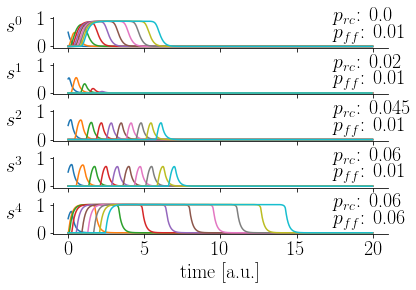

In [5]:
fig, ax = plt.subplots(
    len(r_sel), 1, sharex=True, sharey=True,
    squeeze=False, figsize=(6,4),
    gridspec_kw={
        'hspace': 0.5})
   
for i, r_i in enumerate(r_sel):
    p_rc_i =r_i['p_rc']
    p_ff_i =r_i['p_ff'] 
    
    pos_p_rc_i = np.where(params['range_p_rc'] == p_rc_i)[0][0]
    pos_p_ff_i = np.where(params['range_p_ff'] == p_ff_i)[0][0]
    
    r_ii = r[pos_p_rc_i, pos_p_ff_i]
    seq_i = params['seqs'][0]
    
    #plot rates
    ax[i, 0].plot(t,  r_ii[:, seq_i[::3]*2])
    
    # annotate
    ax[i, 0].spines['right'].set_visible(False)
    ax[i, 0].spines['top'].set_visible(False)
    
    ax[i, 0].text(-4, .5, r'$s^{'+str(i)+'}$')
    ax[i, 0].text(17.3, 0.9, r'$p_{rc}$: '+str(p_rc_i))
    ax[i, 0].text(17.3, 0.3, r'$p_{ff}$: '+str(p_ff_i))

#    ax[i, 0].set_ylim(0.7, 1.)
#ax[2, 0].set_ylabel(r'$r^E$', rotation=0)

ax[-1, 0].set_xlabel('time [a.u.]')
plt.savefig('figures/1_SingleSequence_examples.svg')

### Test for successful reactivation

In [6]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])], dtype=bool)
cond = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff']),
    4], dtype=bool)

mean_t_act = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])])
mean_act = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])])

dt = np.mean(np.unique(np.diff(params['t'])))

seq = params['seqs'][0]
for i, p_rc_i in enumerate(tqdm(params['range_p_rc'])):
    for j, p_ff_i in enumerate(params['range_p_ff']):
        rE_ij = rE[i, j, :, :]        
        (crit[i, j],
         cond[i, j, 0],
         cond[i, j, 1],
         cond[i, j, 2],
         cond[i, j, 3]) = tools_wc.peak_criterium(
             rE_ij, params['r_min'], seq, params['tol'], return_conds=True)
        mean_t_act[i, j] = tools_wc.mean_activation_time(rE_ij, params['r_min'], seq, dt)
        
        rE_ij_without0 = np.copy(rE_ij)
        rE_ij_without0[rE_ij_without0<params['r_min']] = np.nan
        mean_act[i, j] = np.nanmean(rE_ij_without0)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


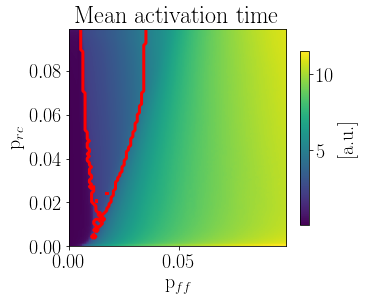

In [7]:
fig, ax = plt.subplots(1, figsize=(5,4))

crt_map = cm.get_cmap()
crt_map.set_bad(color='grey')

#ax.set_aspect('equal')
#mean_t_act[~crit] = np.nan
im = ax.imshow(
    mean_t_act,
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]])
im2 = ax.contour(
    crit,
    levels=[False, True],
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    colors='red',
    linewidths=3.)

#xticks = ax.get_xticks()
#ax.set_yticks(xticks)
cbar = plt.colorbar(im, shrink=0.8)
cbar.ax.set_ylabel('[a.u.]', rotation=90)
plt.xlabel(r'p$_{ff}$')
plt.ylabel(r'p$_{rc}$')

plt.title('Mean activation time')
plt.savefig('figures/1_SingleSequence_MeanActivationTime_prc_pff_scan.svg')

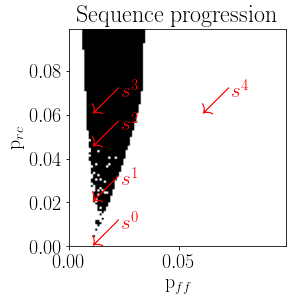

In [8]:
fig, ax = plt.subplots(1, figsize=(5,4))

crt_map = cm.get_cmap()
cmap = mpl.cm.get_cmap('Greys')

#ax.set_aspect('equal')
#mean_t_act[~crit] = np.nan
im = ax.imshow(
    crit,
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    vmin=0,
    vmax=1,
cmap=cmap)
ax.set_xlabel(r'p$_{ff}$')
#xticks = ax.get_xticks()
#ax.set_yticks(xticks)
plt.xlabel(r'p$_{ff}$')
plt.ylabel(r'p$_{rc}$')

for i, r_i in enumerate(r_sel):
    p_rc_i =r_i['p_rc']
    p_ff_i =r_i['p_ff'] 
    plt.text(p_ff_i, p_rc_i,
        r'$\swarrow^{s^'+str(i)+'}$',
        #r'$*^{s^'+str(i)+'}$',
        #r'$\downarrow^{s^'+str(i)+'}$',
             color='r', fontsize=30,
        horizontalalignment='left',
        verticalalignment='bottom')

plt.title('Sequence progression')
plt.savefig('figures/1_SingleSequence_SuccessfulReactivation_prc_pff_scan.svg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


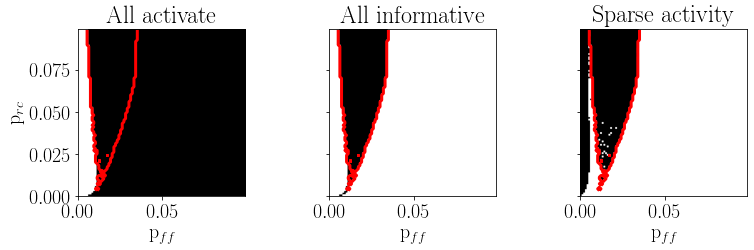

In [9]:
fig, ax = plt.subplots(
    1, 3, figsize=(12,4), sharex=True, sharey=True,
    gridspec_kw={
        'wspace': 0.5})
ls_title = ['All activate', 'All informative', 'Sparse activity']

cmap = mpl.cm.get_cmap('Greys')

for i in range(3):
    im = ax[i].imshow(
        cond[:, :, i],
        origin='lower',
        extent=[
            params['range_p_rc'][0],
            params['range_p_rc'][-1],
            params['range_p_ff'][0],
            params['range_p_ff'][-1]],
        vmin=0,
        vmax=1,
    cmap=cmap)
    ax[i].set_xlabel(r'p$_{ff}$')
    ax[i].set_title(ls_title[i])
    
    ax[i].contour(
    crit,
    levels=[False, True],
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    colors='red',
    linewidths=3.)
ax[0].set_ylabel(r'p$_{rc}$')

fig.tight_layout()

plt.savefig('figures/1_SingleSequence_SuccessfulReactivation_Conditions_prc_pff_scan.svg')

### Investigate white dots inside red region

In [16]:
params['range_p_rc']

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099])

In [20]:
len(params['range_p_ff'])

100

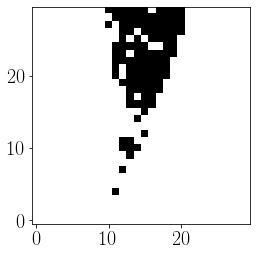

In [27]:
plt.imshow(
        crit[:30, :30],
        origin='lower',
        vmin=0,
        vmax=1,
    cmap=cmap)

array([ True,  True,  True,  True])

In [72]:
pos_p_rc_i = 24
p_rc_i = params['range_p_rc'][pos_p_rc_i]

pos_p_ff_i = 16
p_ff_i = params['range_p_ff'][pos_p_ff_i]

print(cond[pos_p_rc_i, pos_p_ff_i])


r_i = r[pos_p_rc_i, pos_p_ff_i, :, ::2]

[ True  True False  True]


(7.0, 10.0)

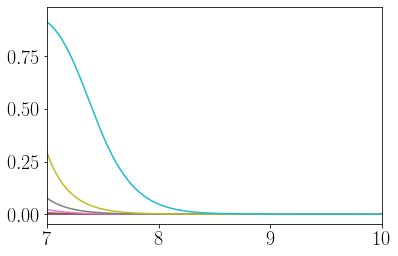

In [76]:
fig, ax = plt.subplots(1)
ax.plot(t,  r_i)
ax.set_xlim(7, 10)

In [74]:
tools_wc.peak_criterium(
             r_i, params['r_min'], seq, params['tol'], return_conds=True, verbose=True)

Condition 0:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
Condition 1:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
Condition 2:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

(False, True, True, False, True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


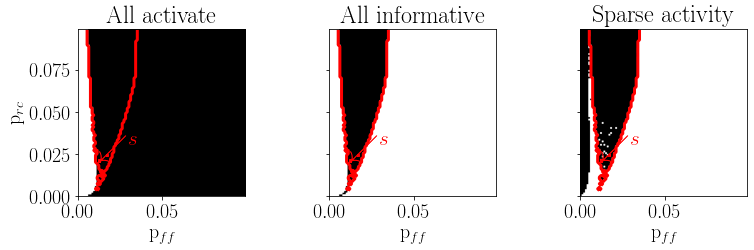

In [32]:
fig, ax = plt.subplots(
    1, 3, figsize=(12,4), sharex=True, sharey=True,
    gridspec_kw={
        'wspace': 0.5})
ls_title = ['All activate', 'All informative', 'Sparse activity']

cmap = mpl.cm.get_cmap('Greys')

for i in range(3):
    im = ax[i].imshow(
        cond[:, :, i],
        origin='lower',
        extent=[
            params['range_p_rc'][0],
            params['range_p_rc'][-1],
            params['range_p_ff'][0],
            params['range_p_ff'][-1]],
        vmin=0,
        vmax=1,
    cmap=cmap)
    ax[i].set_xlabel(r'p$_{ff}$')
    ax[i].set_title(ls_title[i])
    
    ax[i].contour(
    crit,
    levels=[False, True],
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    colors='red',
    linewidths=3.)

    ax[i].text(
        p_ff_i,
        p_rc_i,
        r'$\swarrow^{s}$',
             color='r', fontsize=30,
        horizontalalignment='left',
        verticalalignment='bottom')
    
ax[0].set_ylabel(r'p$_{rc}$')

fig.tight_layout()

plt.savefig('figures/1_SingleSequence_SuccessfulReactivation_Conditions_prc_pff_scan.svg')

In [15]:
            sim = sim_wc.Simulator(params)
            sim.p['p_rc'] = p_rc_i
            sim.p['p_ff'] = p_ff_i
            sim.set_interaction_matrix()

            _, r[i, j, :, :] = sim.run()

ValueError: could not broadcast input array from shape (60,1000) into shape (1000,60)

In [ ]:
plt.plot(r_ii)

In [ ]:
def smooth_step(x, k=10):
    return 1 / (1 + np.exp(-k*(x)))

def custom_function(x, k1=2, k2=10, k3=0.3, bias=0.016805059082205986):
    x = x-k3
    y = smooth_step(x, k=k2) * (1 / (1 + np.exp(-k1*x)))
    y = y-bias
    y = np.maximum(0, y)
    return y

In [ ]:
def ramp_up(x, a=0.01):
    # This function is 0 at x=0 and its derivative is also 0 at x=0
    # The parameter a controls how quickly the function increases
    return np.where(x > 0, a * x**2, 0)

def custom_function2(x, k1=1, k2=10, a=0.01):
    return ramp_up(x, a) + smooth_step(x - a, k=k2) * (1 / (1 + np.exp(-k1*(x - a))))

In [ ]:
def ramp_up_down(x, a=0.01, b=0.1, k=10):
    # This function is 0 at x=0, its derivative is also 0 at x=0
    # It starts increasing with x and then decreases after x=b
    return np.where(x > 0, a * x**2 * (1 - smooth_step((x - b), k)), 0)

def custom_function3(x, k1=1, k2=10, a=0.01, b=0.1):
    return ramp_up_down(x, a, b) + smooth_step(x - b, k=k2) * (1 / (1 + np.exp(-k1*(x - b))))


In [ ]:
x = np.arange(-2, 5, 0.01)
y_smooth = smooth_step(x)
y_sig = sim_wc.activation_function(x, a=0.0001)
y_cust = custom_function(x)
y_cust2 = custom_function2(x)
y_cust3 = custom_function3(x)
plt.plot(x, y_cust, label='cust')
plt.plot(x, y_cust2, label='cust2')
plt.plot(x, y_cust3, label='cust3')
plt.plot(x, y_smooth, label='smooth')
plt.plot(x, y_sig, label='actfun')
plt.legend()
plt.xlim(-0.5, 1)
plt.ylim(-0.01, 0.1)

In [ ]:
offset = 0.016805059082205986